# Advanced RAG with LlamaParse + AstraDB

This notebook shows you how to use LlamaParse with our advanced markdown ingestion and recursive retrieval algorithms to model tables/text within a document hierarchically. This lets you ask questions over both tables and text.

This notebook is similar to our `demo_advanced.ipynb` notebook, with the main difference being AstraDB.

In [ ]:
!pip install llama-index
!pip install llama-index-core==0.10.6.post1
!pip install llama-index-embeddings-openai
!pip install llama-index-postprocessor-flag-embedding-reranker
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git
!pip install llama-parse
!pip install llama-index-vector-stores-astra
!pip install astrapy

In [ ]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10q/uber_10q_march_2022.pdf' -O './uber_10q_march_2022.pdf'

Some OpenAI and LlamaParse details

In [1]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

import os
# API access to llama-cloud
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-"

# Using OpenAI API for embeddings/llms
os.environ["OPENAI_API_KEY"] = "sk-"

ASTRA_API_ENDPOINT = "<enter AstraDB endpoint>"
ASTRA_TOKEN = "<enter your Astra DB Token>"
ASTRA_NAMESPACE = None  # or: "my_keyspace". Must exist on Astra already.

In [2]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings

embed_model=OpenAIEmbedding(model="text-embedding-3-small")
llm = OpenAI(model="gpt-3.5-turbo-0125")

Settings.llm = llm
Settings.embed_model = embed_model

## Using brand new `LlamaParse` PDF reader for PDF Parsing

We feed the Uber March 2022 10QA into LlamaParse to get back the Markdown representation.

In [3]:
from llama_parse import LlamaParse

documents = LlamaParse(result_type="markdown").load_data('./uber_10q_march_2022.pdf')

Started parsing the file under job_id c27837c3-ca0f-4c19-9c5b-205e44f7cc73


In [4]:
print(documents[0].text[:1000] + '...')

## UNITED STATES SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

## FORM 10-Q

(Mark One)

☒ QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended March 31, 2022

OR

☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from_____ to _____

Commission File Number: 001-38902

UBER TECHNOLOGIES, INC.

(Exact name of registrant as specified in its charter)

Not Applicable

(Former name, former address and former fiscal year, if changed since last report)

Delaware 45-2647441

(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)

1515 3rd Street

San Francisco, California 94158

(Address of principal executive offices, including zip code)

(415) 612-8582

(Registrant’s telephone number, including area code)

Securities registered pursuant to Section 12(b) of the Act:

|Title of each class|Trading Symbol(

## Setup AstraDB

In [8]:
from llama_index.vector_stores.astra import AstraDBVectorStore

# define two storage classes representing two collections (to compare advanced approach vs. baseline) 

astra_db_store_advanced = AstraDBVectorStore(
    token=ASTRA_TOKEN,
    api_endpoint=ASTRA_API_ENDPOINT,
    namespace=ASTRA_NAMESPACE,
    collection_name="astra_v_table_llamaparse_advanced",
    embedding_dimension=1536
)
astra_db_store_base = AstraDBVectorStore(
    token=ASTRA_TOKEN,
    api_endpoint=ASTRA_API_ENDPOINT,
    namespace=ASTRA_NAMESPACE,
    collection_name="astra_v_table_llamaparse_base",
    embedding_dimension=1536
)

## Index Data, Get Query Engine

We compare two different retrieval/query engine strategies:
1. Using raw Markdown text as nodes for building index and apply simple query engine for generating the results;
2. Using `MarkdownElementNodeParser` for parsing the `LlamaParse` output Markdown results and building recursive retriever query engine for generation.

In [6]:
from llama_index.core.node_parser import MarkdownElementNodeParser

node_parser = MarkdownElementNodeParser(llm=OpenAI(model="gpt-3.5-turbo-0125"), num_workers=8)

In [ ]:
nodes = node_parser.get_nodes_from_documents(documents)

In [9]:
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

In [10]:
from llama_index.core import StorageContext

storage_context_advanced = StorageContext.from_defaults(vector_store=astra_db_store_advanced)
storage_context_base = StorageContext.from_defaults(vector_store=astra_db_store_base)

recursive_index = VectorStoreIndex(nodes=base_nodes+objects, storage_context=storage_context_advanced)
raw_index = VectorStoreIndex.from_documents(documents, storage_context=storage_context_base)

In [ ]:
from llama_index.postprocessor.flag_embedding_reranker import FlagEmbeddingReranker

reranker = FlagEmbeddingReranker(
    top_n=5,
    model="BAAI/bge-reranker-large",
)

recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=15, 
    node_postprocessors=[reranker], 
    verbose=True
)

raw_query_engine = raw_index.as_query_engine(similarity_top_k=15, node_postprocessors=[reranker])

## Using `new LlamaParse` as pdf data parsing methods and retrieve tables with two different methods
we compare base query engine vs recursive query engine with tables

### Table Query Task: Queries for Table Question Answering

In [12]:
query = "how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)



***********Basic Query Engine***********
$41
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_40_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_322_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_38_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_318_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_52c214

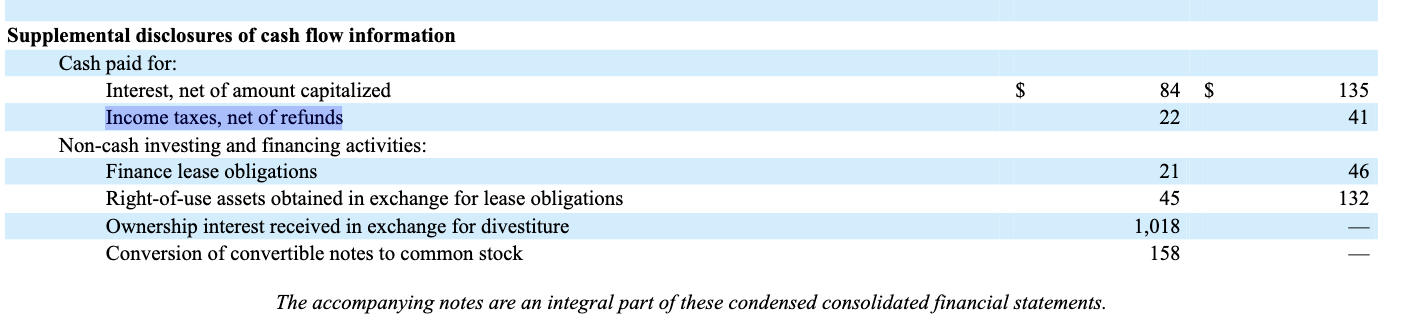

In [13]:
query = "what is the change of free cash flow and what is the rate from the financial and operational highlights?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********Basic Query Engine***********
The change in free cash flow from the financial and operational highlights is a decrease from $(682) million in 2021 to $(47) million in 2022. The rate of change in free cash flow is an improvement of $635 million from 2021 to 2022.
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_318_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_322_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_34_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering id_52c21485-37e1-4c04-b5af

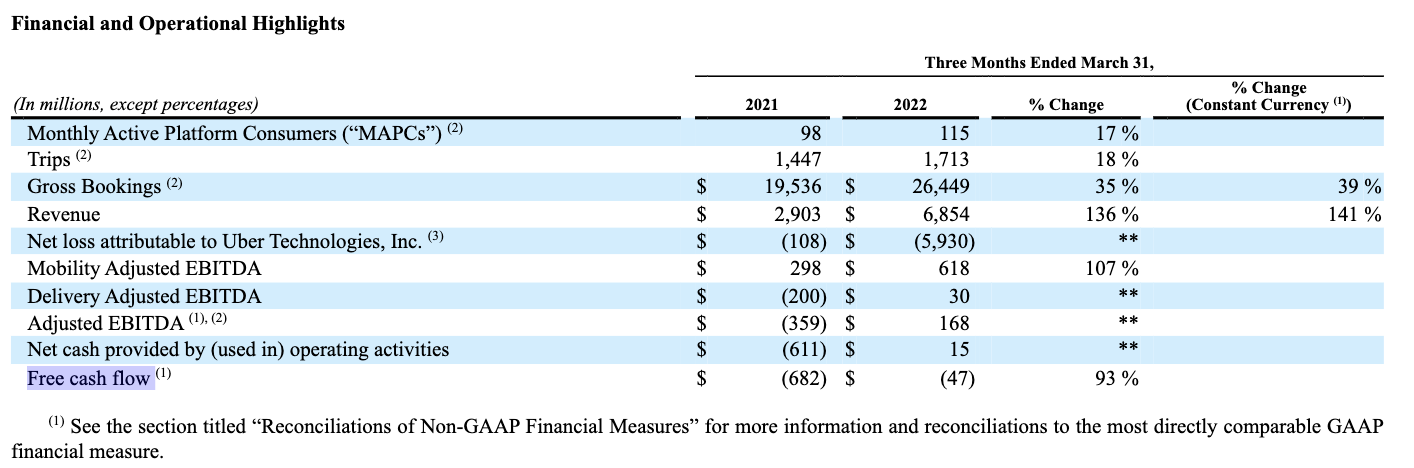

In [14]:
query = "what is the net loss value attributable to Uber compared to last year?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********Basic Query Engine***********
The net loss value attributable to Uber in the current year is $5.9 billion, which is an increase compared to the net loss of $108 million in the same period last year.
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_22_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_228_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_314_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_224_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering

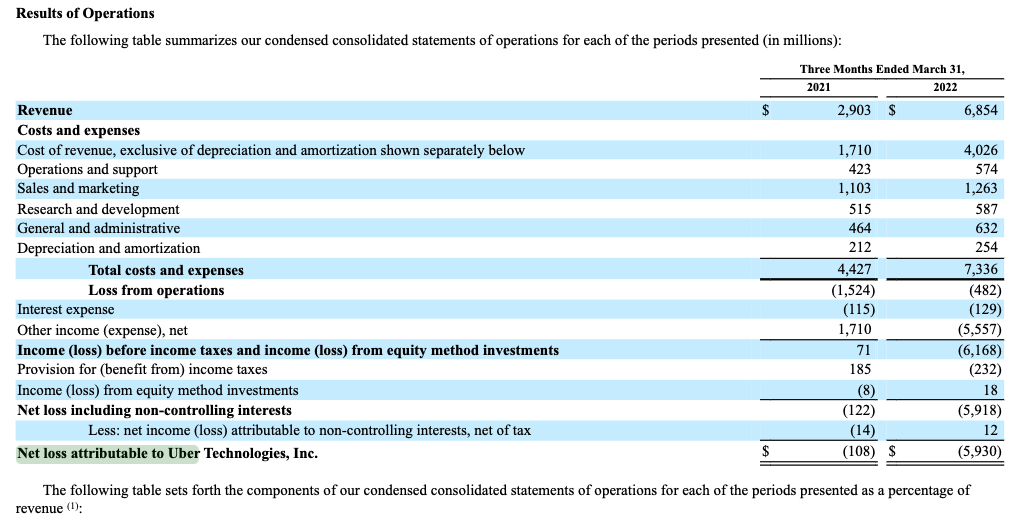

In [15]:
query = "What were cash flows like from investing activities?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********Basic Query Engine***********
Cash flows from investing activities were negative in both 2021 and 2022. In 2021, the net cash used in investing activities was $250 million, while in 2022, it was $135 million. These negative cash flows were primarily driven by purchases of property and equipment, acquisitions of businesses, and purchases of marketable and non-marketable securities.
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_322_table: TextNode
Retrieving from object TextNode with query What were cash flows like from investing activities?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_318_table: TextNode
Retrieving from object TextNode with query What were cash flows like from investing activities?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_40_table: TextNode
Retrieving from object TextNode with query What were cash flows like from investing activities?
Retrieval entering id_52c21485-37e1-4c04-b5af-e42659709ecc_34_table: TextNode
Re

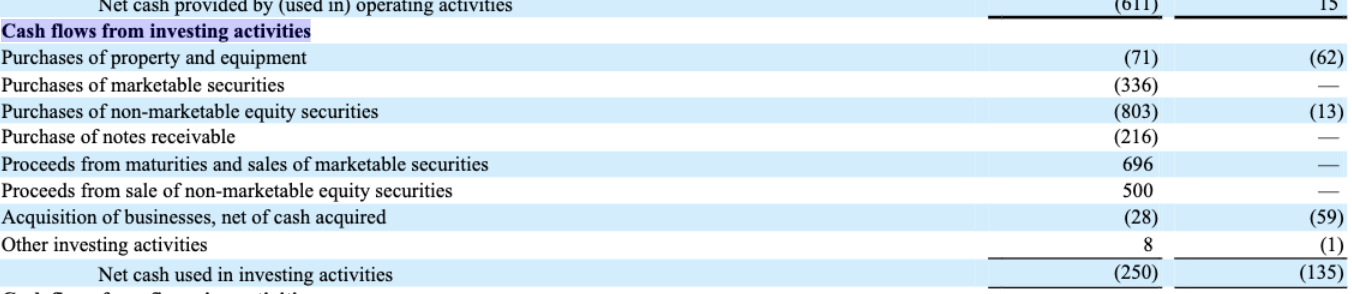